In [1]:
# filter some warning messages
import warnings
warnings.filterwarnings("ignore")

In [2]:
from myfunctions import *
from IcePlot import *

In [3]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [4]:
ms = ["GFDL-CM4", "EC-Earth3", "MPI-ESM1-2-HR"]

p_polynya = "../../SO_data/data_polynya_mean/"
p_ice = "../../SO_data/data_siconc_w_area/"
p_mlotst = "../../SO_data/data_mlotst/"
p_mld = "../../SO_data/data_mld/"
p_thick = "../../SO_data/data_thick/"
p_hfds = "../../SO_data/data_hfds/"

In [5]:
datapd = pd.read_csv('List_model.csv')

In [6]:
x_boundaries = [
    [-220, -120], # ross
    [300, 30], # weddell
    [183, 230], # ross
    [300, 10], # weddell
]

In [6]:
import dask
from dask_jobqueue import PBSCluster
from dask.distributed import Client

In [87]:
# Create a PBS cluster object
cluster = PBSCluster(
    job_name = 'dask-sea-ice',
    cores = 1,
    memory = '16GiB',
    processes = 1,
    local_directory = '~/scratch/dask_scratch/pbs.$PBS_JOBID/dask/spill',
    log_directory = '~/scratch/dask_scratch/pbs.$PBS_JOBID/log',
    resource_spec = 'select=1:ncpus=1:mem=16GB',
    queue = 'casper',
    walltime = '60:00',
    interface = 'ext',
    silence_logs='error',
)

In [88]:
# Create the client to load the Dashboard
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/shunzlu/proxy/42399/status,
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/shunzlu/proxy/42399/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://128.117.208.173:43139,Workers: 0
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/shunzlu/proxy/42399/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [89]:
## you can adjust the number below to get more workers (processing threads)
## the worker number will adapt automatically depending on how heavy the calculation is
cluster.adapt(minimum=2, maximum=50)

In [90]:
data_plot = []
for i in range(2):
    if i == 3:
        m = ms[2]
    else:
        m = ms[i]
    print(m)
    if ispickleexists(m, p_mlotst):
        dsmld = openpickle(m, p_mlotst)
        damld = dsmld.mlotst
    else:
        dsmld = openpickle(m, p_mld)
        damld = dsmld.mld
        
    if x_boundaries[i][0] < x_boundaries[i][1]:
        damld = damld.where(dsmld.newlon > x_boundaries[i][0]).where(dsmld.newlon < x_boundaries[i][1])
    else:
        damld = damld.where((dsmld.newlon > x_boundaries[i][0]) | (dsmld.newlon < x_boundaries[i][1]))
        
    conv_region = damld.where(damld>2000).mean("time")
    dsice = openpickle(m, p_ice)
    dspolynya = openpickle(m, p_polynya)
    ds_hfds = openpickle(m, p_hfds)
    ds_thick = openpickle(m, p_thick)
    ds_thetao = open_from_cloud(datapd.loc[datapd['source_id'] == m]['zstore_thetao'].item())
    
    ts_ice = dsice.siconc.where(conv_region>0).mean((dsice.areacello.dims[0], dsice.areacello.dims[1]))
    ts_hfds = ds_hfds.hfds.where(conv_region>0).mean((ds_hfds.areacello.dims[0], ds_hfds.areacello.dims[1]))
    ts_mld = damld.where(conv_region>0).mean((dsmld.areacello.dims[0], dsmld.areacello.dims[1]))
    thetao_sep = select_month(ds_thetao.thetao, 9).where(conv_region>0).mean((dsmld.areacello.dims[0], dsmld.areacello.dims[1]))
    # if "sithick" in 
    ts_ice_thick = ds_thick.sithick.where(conv_region>0).mean((ds_thick.areacello.dims[0], ds_thick.areacello.dims[1]))
    
    pltd = [ts_ice, ts_ice_thick, ts_hfds, ts_mld, dspolynya, thetao_sep.load(), dsice]
    data_plot.append(pltd)

GFDL-CM4
EC-Earth3


In [91]:
client.shutdown()
cluster.close()

2025-05-09 11:18:16,101 - distributed.deploy.adaptive_core - INFO - Adaptive stop


In [92]:
with open("f2data_2.pickle", 'wb') as wf:
    pickle.dump(data_plot, wf, pickle.HIGHEST_PROTOCOL)

In [7]:
data_plot = openpickle("f2data_2","")

<Figure size 400x500 with 0 Axes>

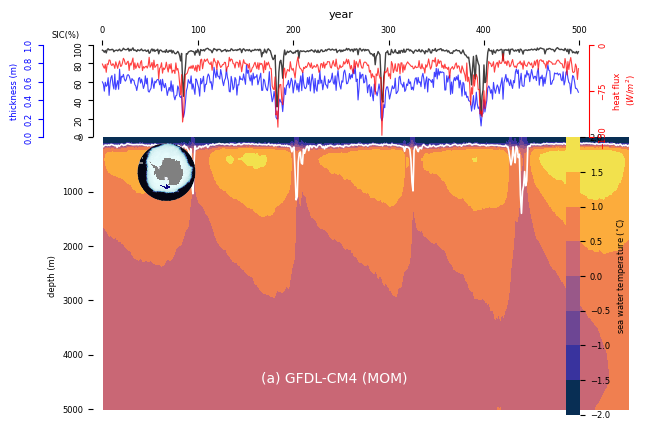

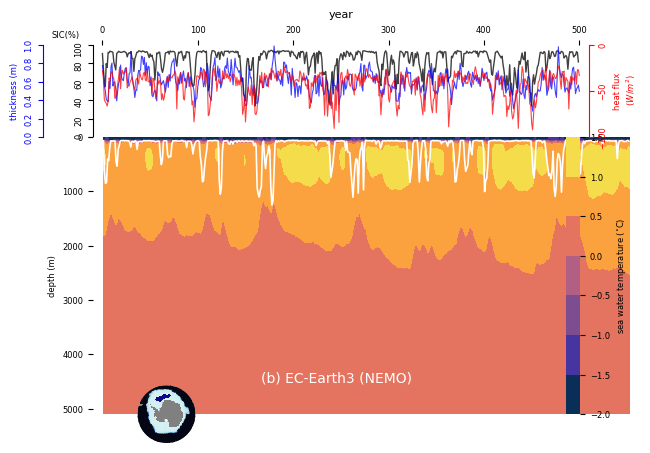

In [83]:
fig = plt.figure(layout='constrained', figsize=(4, 5))

subfigs = fig.subfigures(2, 1, hspace=0.01)
sfigs = subfigs.flatten()
map_position = [[0.155, 0.555, 0.17, 0.12], [0.155, 0.05, 0.17, 0.12]]  # [left, bottom, width, height]# Add the new axes to the figure
    
for j in range(2):
    plt_data = data_plot[j]
    fig = plt.figure()
    gs = fig.add_gridspec(2, 1, hspace=0, height_ratios=[1, 3])
    axs = gs.subplots(sharex=True)


    # axs = sfigs[j].subplots(2, 1, height_ratios=[1, 3], sharex=True)
    # sfigs[j].subplots_adjust(bottom=0.01, top=0.99, left=0.01, right=0.99, hspace=0)
    
    axs[0].plot(range(len(plt_data[0].time)), plt_data[0], color = 'k', linewidth = 1, alpha = 0.75)
    m = axs[1].contourf(range(len(plt_data[5].time)), plt_data[5].lev, 
                    plt_data[5].transpose(), cmap = cmocean.cm.thermal)
    axs[1].plot(range(len(plt_data[3].time)), plt_data[3], color = 'w', linestyle = "-", linewidth = 1.2)
    if j == 0:
        plottext = "(a) GFDL-CM4 (MOM)"
    else:
        plottext = "(b) EC-Earth3 (NEMO)"
    axs[1].text(150, 4500, plottext, color = 'w')
    
    cbar = plt.colorbar(m, fraction=0.046, pad=-0.15)   
    cbar.ax.tick_params(labelsize=6) 
    cbar.outline.set_visible(False)
    cbar.set_label("sea water temperature ($^{\circ}$C)", fontsize = 6)

    axs[0].spines[:].set_visible(False)
    axs[0].spines.left.set_visible(True)
    axs[0].set_ylabel("SIC(%)", fontsize = 6, rotation='horizontal')
    axs[0].yaxis.set_label_coords(-0.055, 1.06)
    axs[0].set_title("year", fontsize = 8)
    axs[0].tick_params(top=True, labeltop=True, bottom=False, labelbottom=False)
    axs[0].tick_params(axis='y', labelrotation=90)
    axs[0].set_ylim(0,100)
    axs[0].set_xlim(-10, 510)
    # axs[0].grid(visible = True, which = "major", axis = "y")

    axs[1].tick_params(axis='both', which='major', labelsize=6)
    axs[0].tick_params(axis='both', which='major', labelsize=6)
    
    axs[1].spines[:].set_visible(False)
    axs[1].set_ylim(0, 5100)
    axs[1].invert_yaxis()
    axs[1].set_ylabel("depth (m)", fontsize = 6)
    axs[1].tick_params(axis='x', which='both', bottom=False, labelbottom=False)

    twin1 = axs[0].twinx()
    p2, = twin1.plot(range(len(plt_data[1].time)), plt_data[1], color = 'b', linestyle = "-", linewidth = 0.8, alpha = 0.75)
    twin1.spines[:].set_visible(False)
    twin1.spines.left.set_visible(True)
    twin1.spines.left.set_color(p2.get_color())
    twin1.spines.left.set_position(("axes", -0.10))
    twin1.tick_params(left=True, labelleft=True, right=False, labelright=False)
    twin1.tick_params(axis='both', which='major', labelsize=6)
    twin1.tick_params(axis='y', colors=p2.get_color(), labelrotation=90)
    twin1.set_ylabel("thickness (m)", fontsize = 6, color = p2.get_color())
    twin1.yaxis.set_label_position("left")
    twin1yticks = twin1.get_yticklabels()
    for ytl in twin1yticks:
        ytl.set_verticalalignment('center')
    twin1.set_ylim(0,1)

    
    twin2 = axs[0].twinx()
    
    p3, = twin2.plot(range(len(plt_data[2].time)), plt_data[2], color = 'r', linestyle = "-", linewidth = 0.8, alpha = 0.75)
    twin2.spines[:].set_visible(False)
    twin2.spines.right.set_visible(True)
    twin2.spines.right.set_color(p3.get_color())
    if j <1:
        twin2.set_yticks([0,-75, -150])
        twin2.set_ylim(-150,0)
    else:
        twin2.set_yticks([0,-50, -100])
        twin2.set_ylim(-100,0)
    twin2.tick_params(axis='both', which='major', labelsize=6)
    twin2.tick_params(axis='y', colors=p3.get_color(), labelrotation=90) 
    twin2yticks = twin2.get_yticklabels()
    for ytl in twin2yticks:
        ytl.set_verticalalignment('center')
    twin2.set_ylabel("heat flux\n ($W/m^2$)", fontsize = 6, color = p3.get_color())

    map_ax = fig.add_axes(map_position[j], zorder=1, projection=ccrs.SouthPolarStereo())
    modify_map(map_ax)
    map_ax.pcolormesh(plt_data[6].newlon, plt_data[6].newlat, plt_data[6].siconc.max("time"), 
                      vmin = 0, vmax=100, transform=ccrs.PlateCarree(), cmap=cmocean.cm.ice)
    polynya_freq = plt_data[4].count("time")/len(plt_data[4].time)
    map_ax.pcolormesh(plt_data[6].newlon, plt_data[6].newlat, polynya_freq.where(polynya_freq>0), 
                      vmin = 0, vmax=100, transform=ccrs.PlateCarree(), cmap=plt.cm.plasma)

# fig.savefig("timeseries.png", dpi = 300)

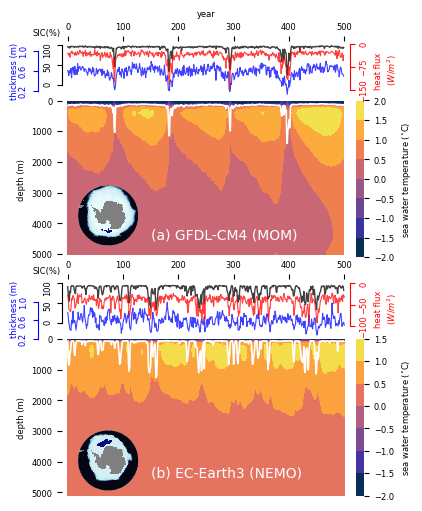

In [92]:
fig = plt.figure(figsize=(4, 5))
axs = fig.subplots(2,1)
fig.subplots_adjust(bottom=0.02, top=0.93, left = 0.135, right = 0.89, hspace=0.1)
map_position = [[0.16, 0.52, 0.18, 0.12], [0.16, 0.03, 0.18, 0.12]]  # [left, bottom, width, height]# Add the new axes to the figure
    
for j in range(2):
    plt_data = data_plot[j]
    m = axs[j].contourf(range(len(plt_data[5].time)), plt_data[5].lev, 
                    plt_data[5].transpose(), cmap = cmocean.cm.thermal)
    axs[j].plot(range(len(plt_data[3].time)), plt_data[3], 
                color = 'w', linestyle = "-", linewidth = 1.2)
    if j == 0:
        plottext = "(a) GFDL-CM4 (MOM)"
    else:
        plottext = "(b) EC-Earth3 (NEMO)"
    axs[j].text(150, 4500, plottext, color = 'w')
    divider = make_axes_locatable(axs[j])

    cax1 = divider.append_axes("right", size="3%", pad="2%")
    cbar = fig.colorbar(m, cax=cax1)
    cbar.ax.tick_params(labelsize=6) 
    cbar.outline.set_visible(False)
    cbar.set_label("sea water temperature ($^{\circ}$C)", fontsize = 6)

    axs[j].spines[:].set_visible(False)
    axs[j].set_ylim(0, 5100)
    axs[j].invert_yaxis()
    axs[j].set_ylabel("depth (m)", fontsize = 6)
    axs[j].tick_params(axis='x', which='both', bottom=False, labelbottom=False)
    axs[j].tick_params(axis='both', which='major', labelsize=6)
    
    
    ax0 = divider.append_axes("top", 0.6, pad=0, sharex=axs[j])
    ax0.plot(range(len(plt_data[0].time)), plt_data[0], color = 'k', 
             linewidth = 1, alpha = 0.75)
    ax0.set_xlim(-10, 510)
    ax0.spines[:].set_visible(False)
    ax0.spines.left.set_visible(True)
    ax0.set_ylabel("SIC(%)", fontsize = 6, rotation='horizontal')
    ax0.yaxis.set_label_coords(-0.055, 1.06)
    # ax0.set_title("year", fontsize = 8)
    ax0.xaxis.set_label_position("top")
    if j<1:
        ax0.set_xlabel("year", fontsize = 6)
    ax0.tick_params(top=True, labeltop=True, bottom=False, labelbottom=False)
    ax0.tick_params(axis='y', labelrotation=90)
    ax0.tick_params(axis='both', which='major', labelsize=6)
    ax0.set_ylim(-40,110)
    ax0.spines.left.set_bounds(0, 100)
    

    twin1 = ax0.twinx()
    p2, = twin1.plot(range(len(plt_data[1].time)), plt_data[1], color = 'b', 
                     linestyle = "-", linewidth = 0.8, alpha = 0.75)
    twin1.spines[:].set_visible(False)
    twin1.spines.left.set_visible(True)
    twin1.spines.left.set_color(p2.get_color())
    twin1.spines.left.set_position(("axes", -0.085))
    twin1.tick_params(left=True, labelleft=True, right=False, labelright=False)
    twin1.tick_params(axis='both', which='major', labelsize=6)
    twin1.tick_params(axis='y', colors=p2.get_color(), labelrotation=90)
    twin1.set_ylabel("thickness (m)", fontsize = 6, 
                     color = p2.get_color())
    twin1.yaxis.set_label_coords(-0.15, 0.5)
    twin1.yaxis.set_label_position("left")
    twin1yticks = twin1.get_yticklabels()
    for ytl in twin1yticks:
        ytl.set_verticalalignment('center')
    if j<1:
        twin1.set_ylim(0, 1.2)
        twin1.spines.left.set_bounds(0.2, 1.0)
        twin1.set_yticks([0.2, 0.6, 1.0])
    else:
        twin1.set_ylim(0.2, 1.5)
        twin1.spines.left.set_bounds(0.2, 1.0)
        twin1.set_yticks([0.2, 0.6, 1.0])
    
    
    twin2 = ax0.twinx()
    
    p3, = twin2.plot(range(len(plt_data[2].time)), plt_data[2], color = 'r', 
                     linestyle = "-", linewidth = 0.8, alpha = 0.75)
    twin2.spines[:].set_visible(False)
    twin2.spines.right.set_visible(True)
    twin2.spines.right.set_color(p3.get_color())
    if j <1:
        twin2.set_yticks([0,-75, -150])
        twin2.set_ylim(-185,10)
        twin2.spines.right.set_bounds(-150, 0)
    else:
        twin2.set_yticks([0,-50, -100])
        twin2.set_ylim(-130,10)
        twin2.spines.right.set_bounds(-100, 0)
    twin2.tick_params(axis='both', which='major', labelsize=6)
    twin2.tick_params(axis='y', colors=p3.get_color(), labelrotation=90) 
    twin2yticks = twin2.get_yticklabels()
    for ytl in twin2yticks:
        ytl.set_verticalalignment('center')
    twin2.set_ylabel("heat flux\n ($W/m^2$)", fontsize = 6, color = p3.get_color())

    map_ax = fig.add_axes(map_position[j], zorder=1, projection=ccrs.SouthPolarStereo())
    modify_map(map_ax)
    map_ax.pcolormesh(plt_data[6].newlon, plt_data[6].newlat, plt_data[6].siconc.max("time"), 
                      vmin = 0, vmax=100, transform=ccrs.PlateCarree(), cmap=cmocean.cm.ice)
    polynya_freq = plt_data[4].count("time")/len(plt_data[4].time)
    map_ax.pcolormesh(plt_data[6].newlon, plt_data[6].newlat, polynya_freq.where(polynya_freq>0), 
                      vmin = 0, vmax=100, transform=ccrs.PlateCarree(), cmap=plt.cm.plasma)

fig.savefig("timeseries2.png", dpi = 300)